# Ширење на вируси на ER мрежи

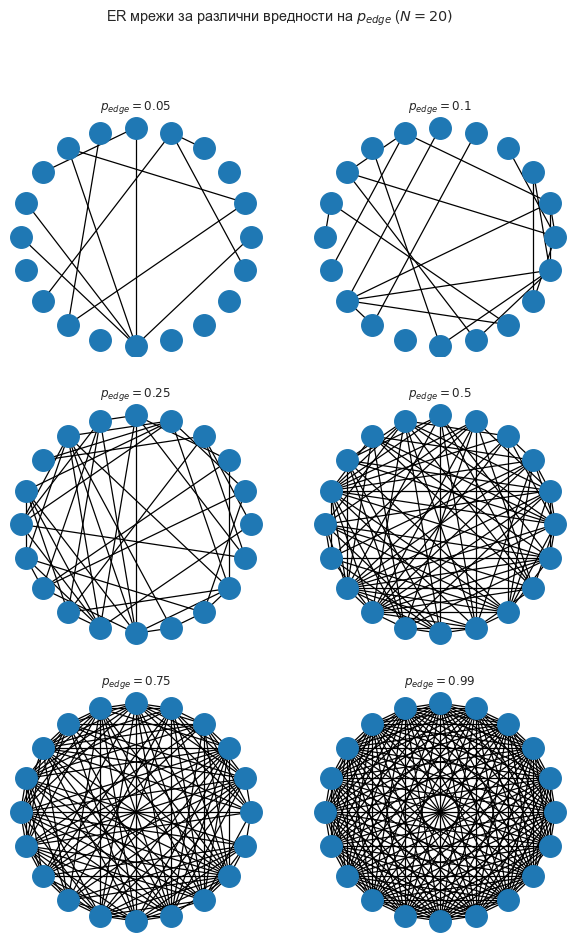

In [3]:
"""

 Created on 20-Feb-21
 @author: Kiril Zelenkovski

"""
import networkx
import matplotlib
import matplotlib.pyplot as plt
import seaborn
matplotlib.rcParams['figure.dpi'] = 90

matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=.8)

(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True,
                          figsize=(8, 12))

# a small network to visualise
N = 20

# draw the network for different values of phi
for (phi, ax) in [(0.05, axs[0][0]),
                  (0.10, axs[0][1]),
                  (0.25, axs[1][0]),
                  (0.50, axs[1][1]),
                  (0.75, axs[2][0]),
                  (0.99, axs[2][1])]:
    # create a random ER network
    G = networkx.erdos_renyi_graph(N, phi)

    # draw the network in the sub-plot
    networkx.draw_circular(G, ax=ax)
    ax.set_title('$p_{edge} = ' + '{p}$'.format(p=phi))

# fine-tune the figure
plt.suptitle('ER мрежи за различни вредности на $p_{edge}$ ' + '($N = {n})$'.format(n=N))
plt.savefig('images/2_2_1_er-networks-p.png')
plt.show()

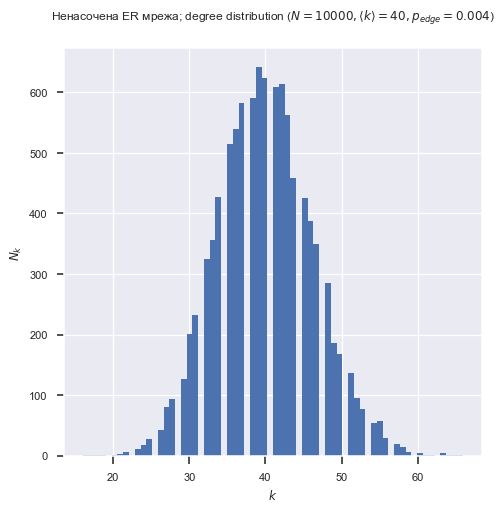

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# a sample network
N = 10000
kmean = 40
phi = (kmean + 0.0) / N

# build the network
g = networkx.gnp_random_graph(N, phi)
#G = networkx.erdos_renyi_graph(N, phi)

# draw the degree distribution
ks = list(dict(networkx.degree(g)).values())
ax.hist(ks, bins=max(ks))
ax.set_title('Ненасочена ER мрежа; degree distribution ($N = {n}, \\langle k \\rangle = {k}'.format(n=N, k=kmean) + ', p_{edge} = ' + '{p}$)'.format(p=phi), y=1.05)
ax.set_xlabel('$k$')
ax.set_ylabel('$N_k$')

plt.savefig('images/2_2_2_degree-distribution-er.png')
plt.show()

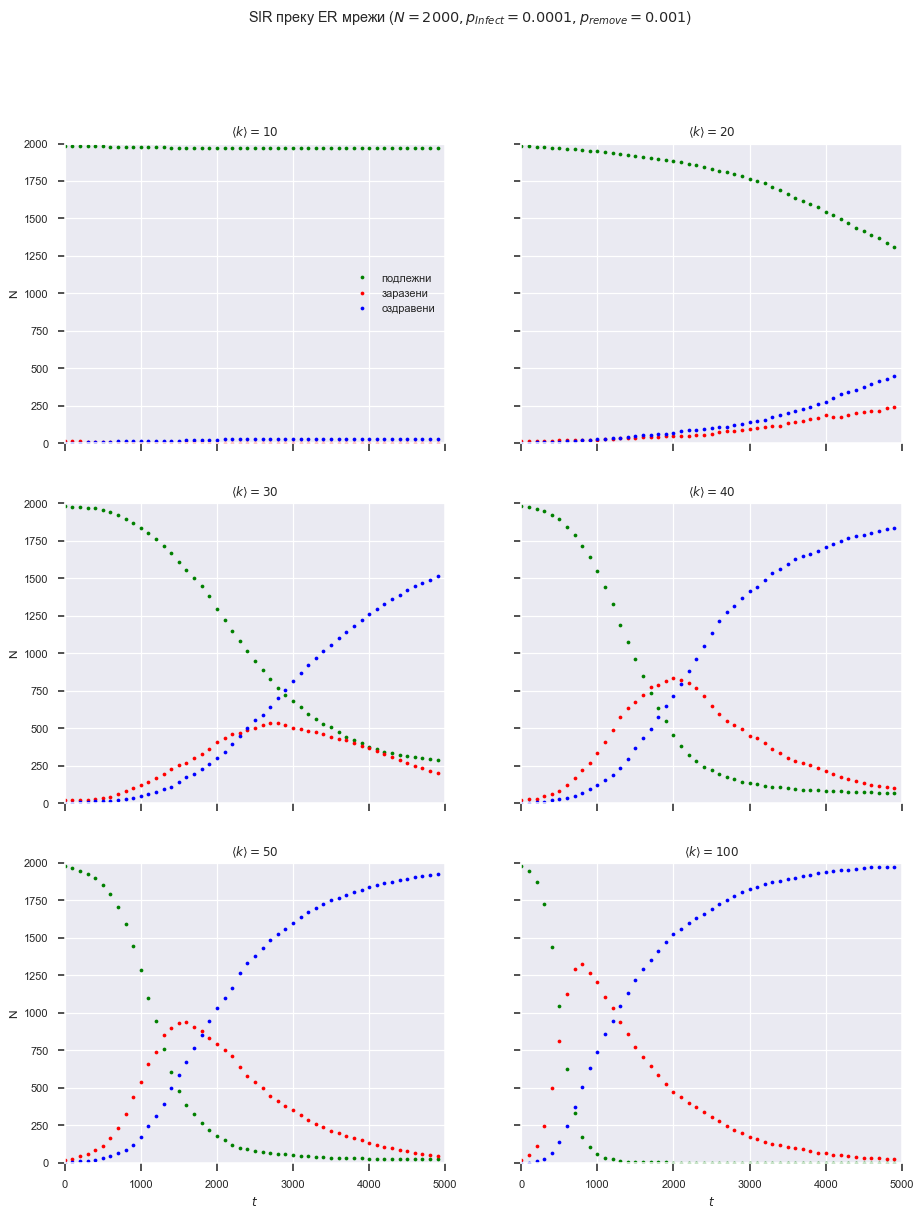

In [6]:
"""

 Created on 20-Feb-21
 @author: Kiril Zelenkovski

"""
import epydemic
import networkx
import matplotlib.pyplot as plt

N = 2000
T = 5000
pInfected = 0.01
pInfect = 0.0001
pRemove = 0.001



class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
    '''A monitored epidemic.'''''

    def __init__(self):
        super(MonitoredSIR, self).__init__()

    def build(self, params):
        '''Build the observation process.

        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)


def network_sir(T, g, pInfected, pInfect, pRemove):
    # create the simulator
    m = MonitoredSIR()
    m.setMaximumTime(T)
    e = epydemic.SynchronousDynamics(m, g)

    # set the simulation parameters
    param = dict()
    param[epydemic.SIR.P_INFECTED] = pInfected
    param[epydemic.SIR.P_INFECT] = pInfect
    param[epydemic.SIR.P_REMOVE] = pRemove
    param[epydemic.Monitor.DELTA] = T / 50

    # run the simulation
    rc = e.set(param).run()

    # extract the time series
    results = e.experimentalResults()[MonitoredSIR.TIMESERIES]
    ts = results[MonitoredSIR.OBSERVATIONS]
    sss = results[epydemic.SIR.SUSCEPTIBLE]
    iss = results[epydemic.SIR.INFECTED]
    rss = results[epydemic.SIR.REMOVED]

    # return the time series
    return (ts, sss, iss, rss)


epidemics = {}
for kmean in [10, 20, 30, 40, 50, 100]:
    # create an ER network
    phi = (kmean + 0.0) / N
    g = networkx.gnp_random_graph(N, phi)

    # run the corresponding simulation
    epidemics[kmean] = network_sir(T, g, pInfected, pInfect, pRemove)

(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 15))

# draw sub-plots for the different values of kmean
for (kmean, ax) in [(10, axs[0][0]),
                    (20, axs[0][1]),
                    (30, axs[1][0]),
                    (40, axs[1][1]),
                    (50, axs[2][0]),
                    (100, axs[2][1])]:
    (sim_ts, sim_sss, sim_iss, sim_rss) = epidemics[kmean]
    ax.plot(sim_ts, sim_sss, 'g.', label='подлежни')
    ax.plot(sim_ts, sim_iss, 'r.', label='заразени')
    ax.plot(sim_ts, sim_rss, 'b.', label='оздравени')
    ax.set_title('$\\langle k \\rangle = {k}$'.format(k=kmean))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])

# fine-tune the figure
plt.suptitle('SIR преку ER мрежи ($N = {n}'.format(n=N) + ', p_{\\mathit{Infect}} = ' + '{b:.4f}'.format(
    b=pInfect) + ', p_{remove} = ' + '{a}$)'.format(a=pRemove))
for i in [0, 1, 2]:
    axs[i][0].set_ylabel('N')
for i in [0, 1]:
    axs[2][i].set_xlabel('$t$')
axs[0][0].legend(loc='center right')

plt.savefig('images/2_3_ER-SIR.png')
plt.show()